#### Курсовой проект: предсказание среднего балла на ЕГЭ по математике, задача регрессии

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams.update({'font.size':14})

In [4]:
df =  pd.read_csv('train.csv')

In [5]:
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [7]:
df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


__Анализ целевой переменной__

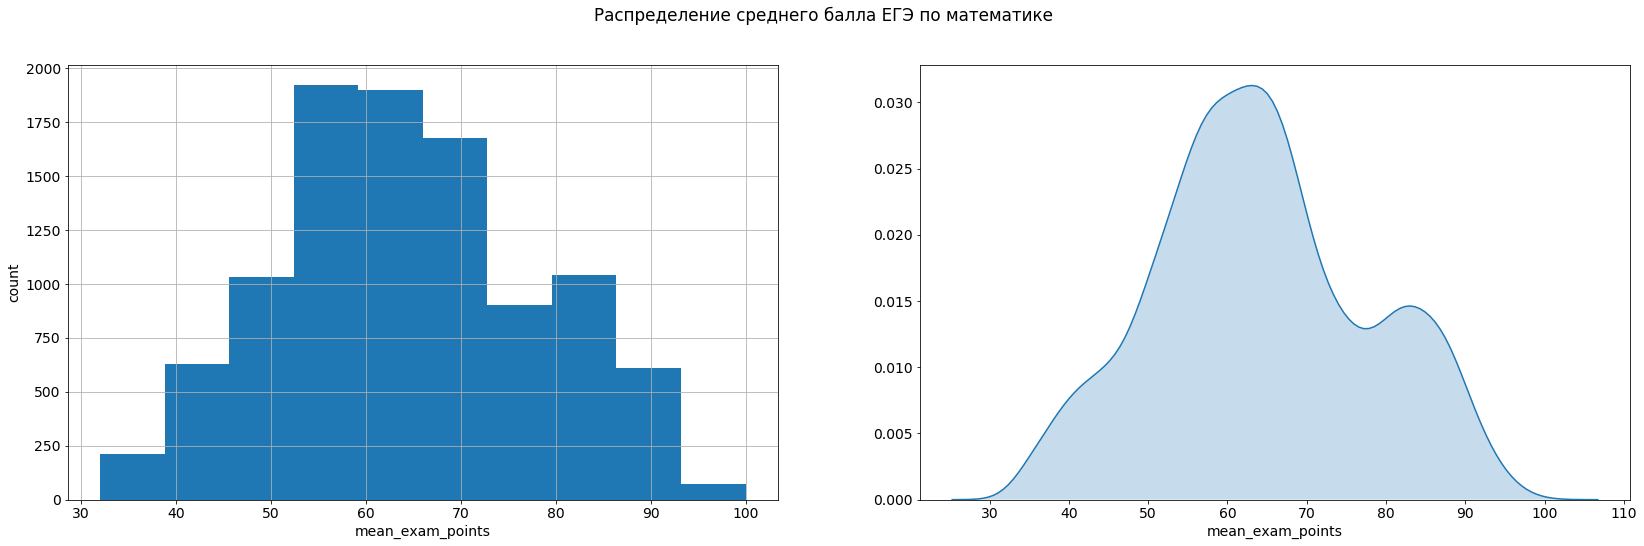

In [8]:
plt.figure(figsize=(28,8))
plt.subplot(121)
df['mean_exam_points'].hist()
plt.ylabel('count')
plt.xlabel('mean_exam_points')
plt.subplot(122)
sns.kdeplot(df['mean_exam_points'], shade=True, legend=False)
plt.xlabel('mean_exam_points')
plt.suptitle('Распределение среднего балла ЕГЭ по математике')
plt.show()

In [9]:
target_mean = df['mean_exam_points'].mean()
target_median = df['mean_exam_points'].median()
target_mode = df['mean_exam_points'].mode()[0]

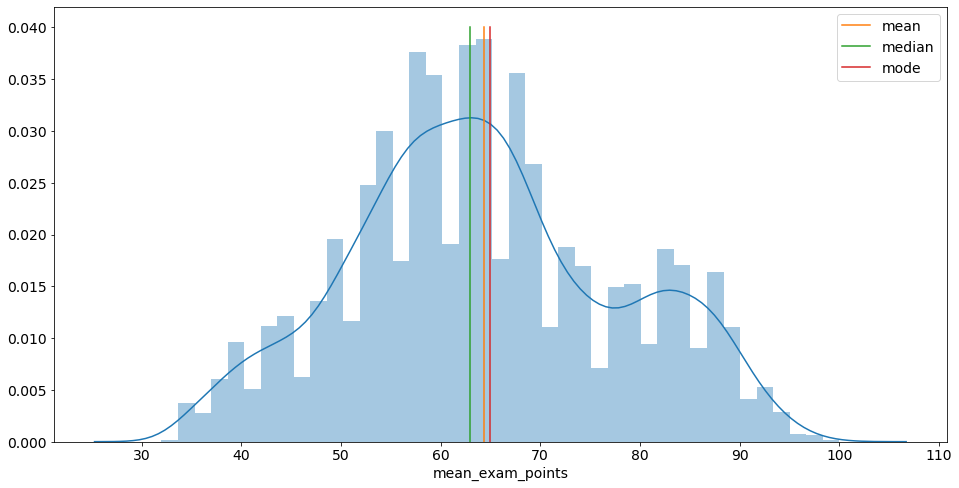

In [10]:
plt.figure(figsize=(16,8))
sns.distplot(df['mean_exam_points'])
y = np.linspace(0, 0.04, 100)
plt.plot([target_mean]*100, y, label='mean')
plt.plot([target_median]*100, y, label='median')
plt.plot([target_mode]*100, y, label='mode')
plt.legend()
plt.show()

В целом, распределение с некоторой погрешностью можно сказать похоже на нормальное.
Посмотрим, есть ли преподаватели, которые ведут несколько предметов

In [11]:
columns = df.columns.values.tolist()
columns

['Id',
 'age',
 'years_of_experience',
 'lesson_price',
 'qualification',
 'physics',
 'chemistry',
 'biology',
 'english',
 'geography',
 'history',
 'mean_exam_points']

In [12]:
df['multi_subjects'] = sum([df[columns[i]] for i in range(5, 11)])
df['multi_subjects'].describe()

count    10000.000000
mean         0.722700
std          0.747302
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: multi_subjects, dtype: float64

Есть, но их меньше 25%

In [13]:
df['subjects'] = None
for i in range(df.shape[0]):
    sbjc = [columns[j] for j in range(5, 11) if df[columns[j]][i]]
    df.loc[i, 'subjects'] = sbjc[0] if len(sbjc) > 0 else 'other'

In [14]:
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,multi_subjects,subjects
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0,2.0,physics
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0,1.0,physics
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,other
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,other
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.0,other


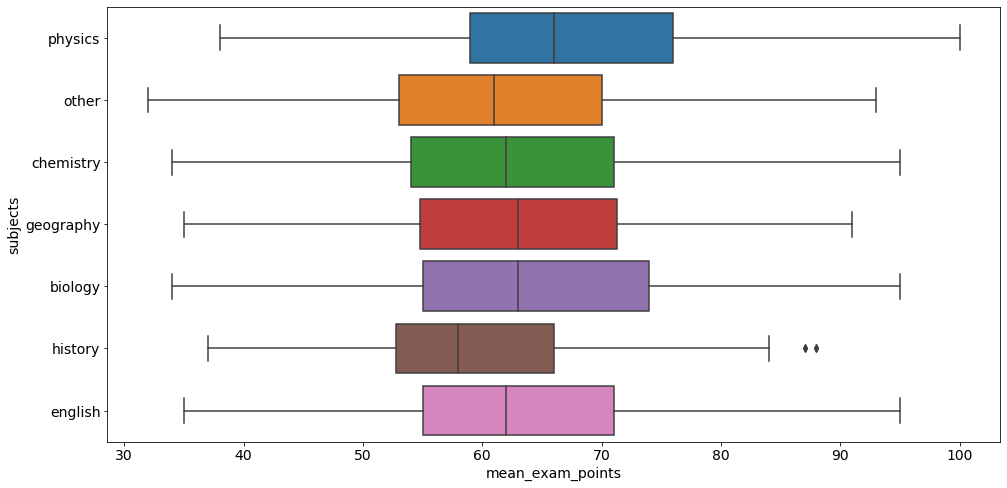

In [15]:
plt.figure(figsize=(16,8))
sns.boxplot(df['mean_exam_points'], df['subjects'])
plt.show()

распределения очень похожи между собой, но можно заметить некоторые смещения у истории и физики. Посмотрим что за выбросы у истории

In [16]:
df.loc[(df['history']>0) & (df['mean_exam_points']>85)]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,multi_subjects,subjects
1866,1866,34.0,3.0,2500.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,90.0,2.0,physics
2003,2003,34.0,2.0,2800.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,91.0,2.0,physics
3036,3036,39.0,3.0,2950.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,89.0,2.0,biology
3498,3498,60.0,9.0,2950.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,94.0,3.0,physics
3642,3642,57.0,0.0,2200.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,88.0,2.0,physics
4260,4260,39.0,3.0,2450.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,87.0,1.0,history
4489,4489,50.0,2.0,2250.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,87.0,2.0,physics
4803,4803,49.0,5.0,3150.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,91.0,2.0,physics
5327,5327,41.0,3.0,2700.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,89.0,3.0,physics
6946,6946,49.0,5.0,3350.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,88.0,1.0,history


Можно заметить что как правило это преподаватели нескольких предметов, за исключением 4 случаев, которые, возможно, целесообразно будет удалить из обучающей выборки

__Анализ признаков__

In [17]:
df_features = df.select_dtypes(include='float64')

<Figure size 1296x1296 with 0 Axes>

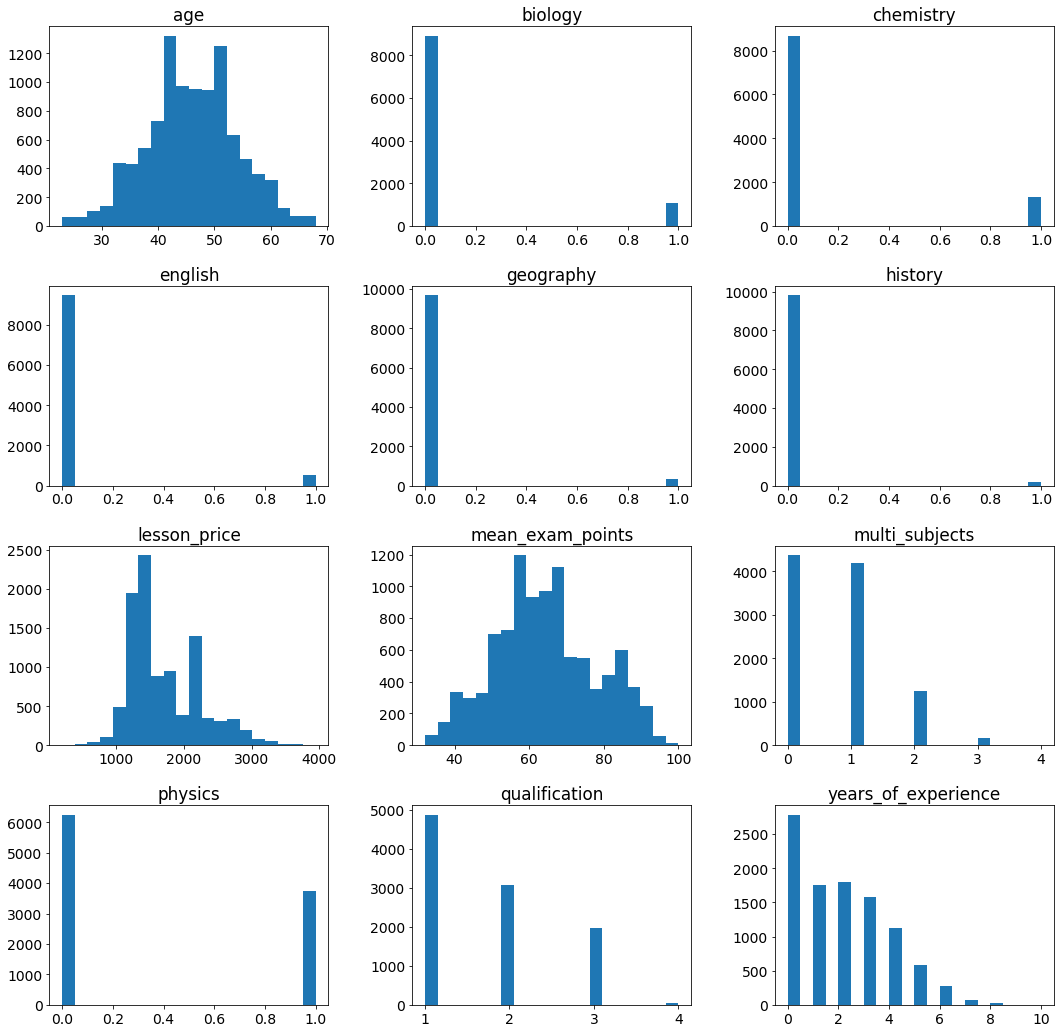

In [18]:
plt.figure(figsize=(18,18))
df_features.hist(figsize=(18,18), bins=20, grid=False)
plt.show()

<Figure size 1296x1296 with 0 Axes>

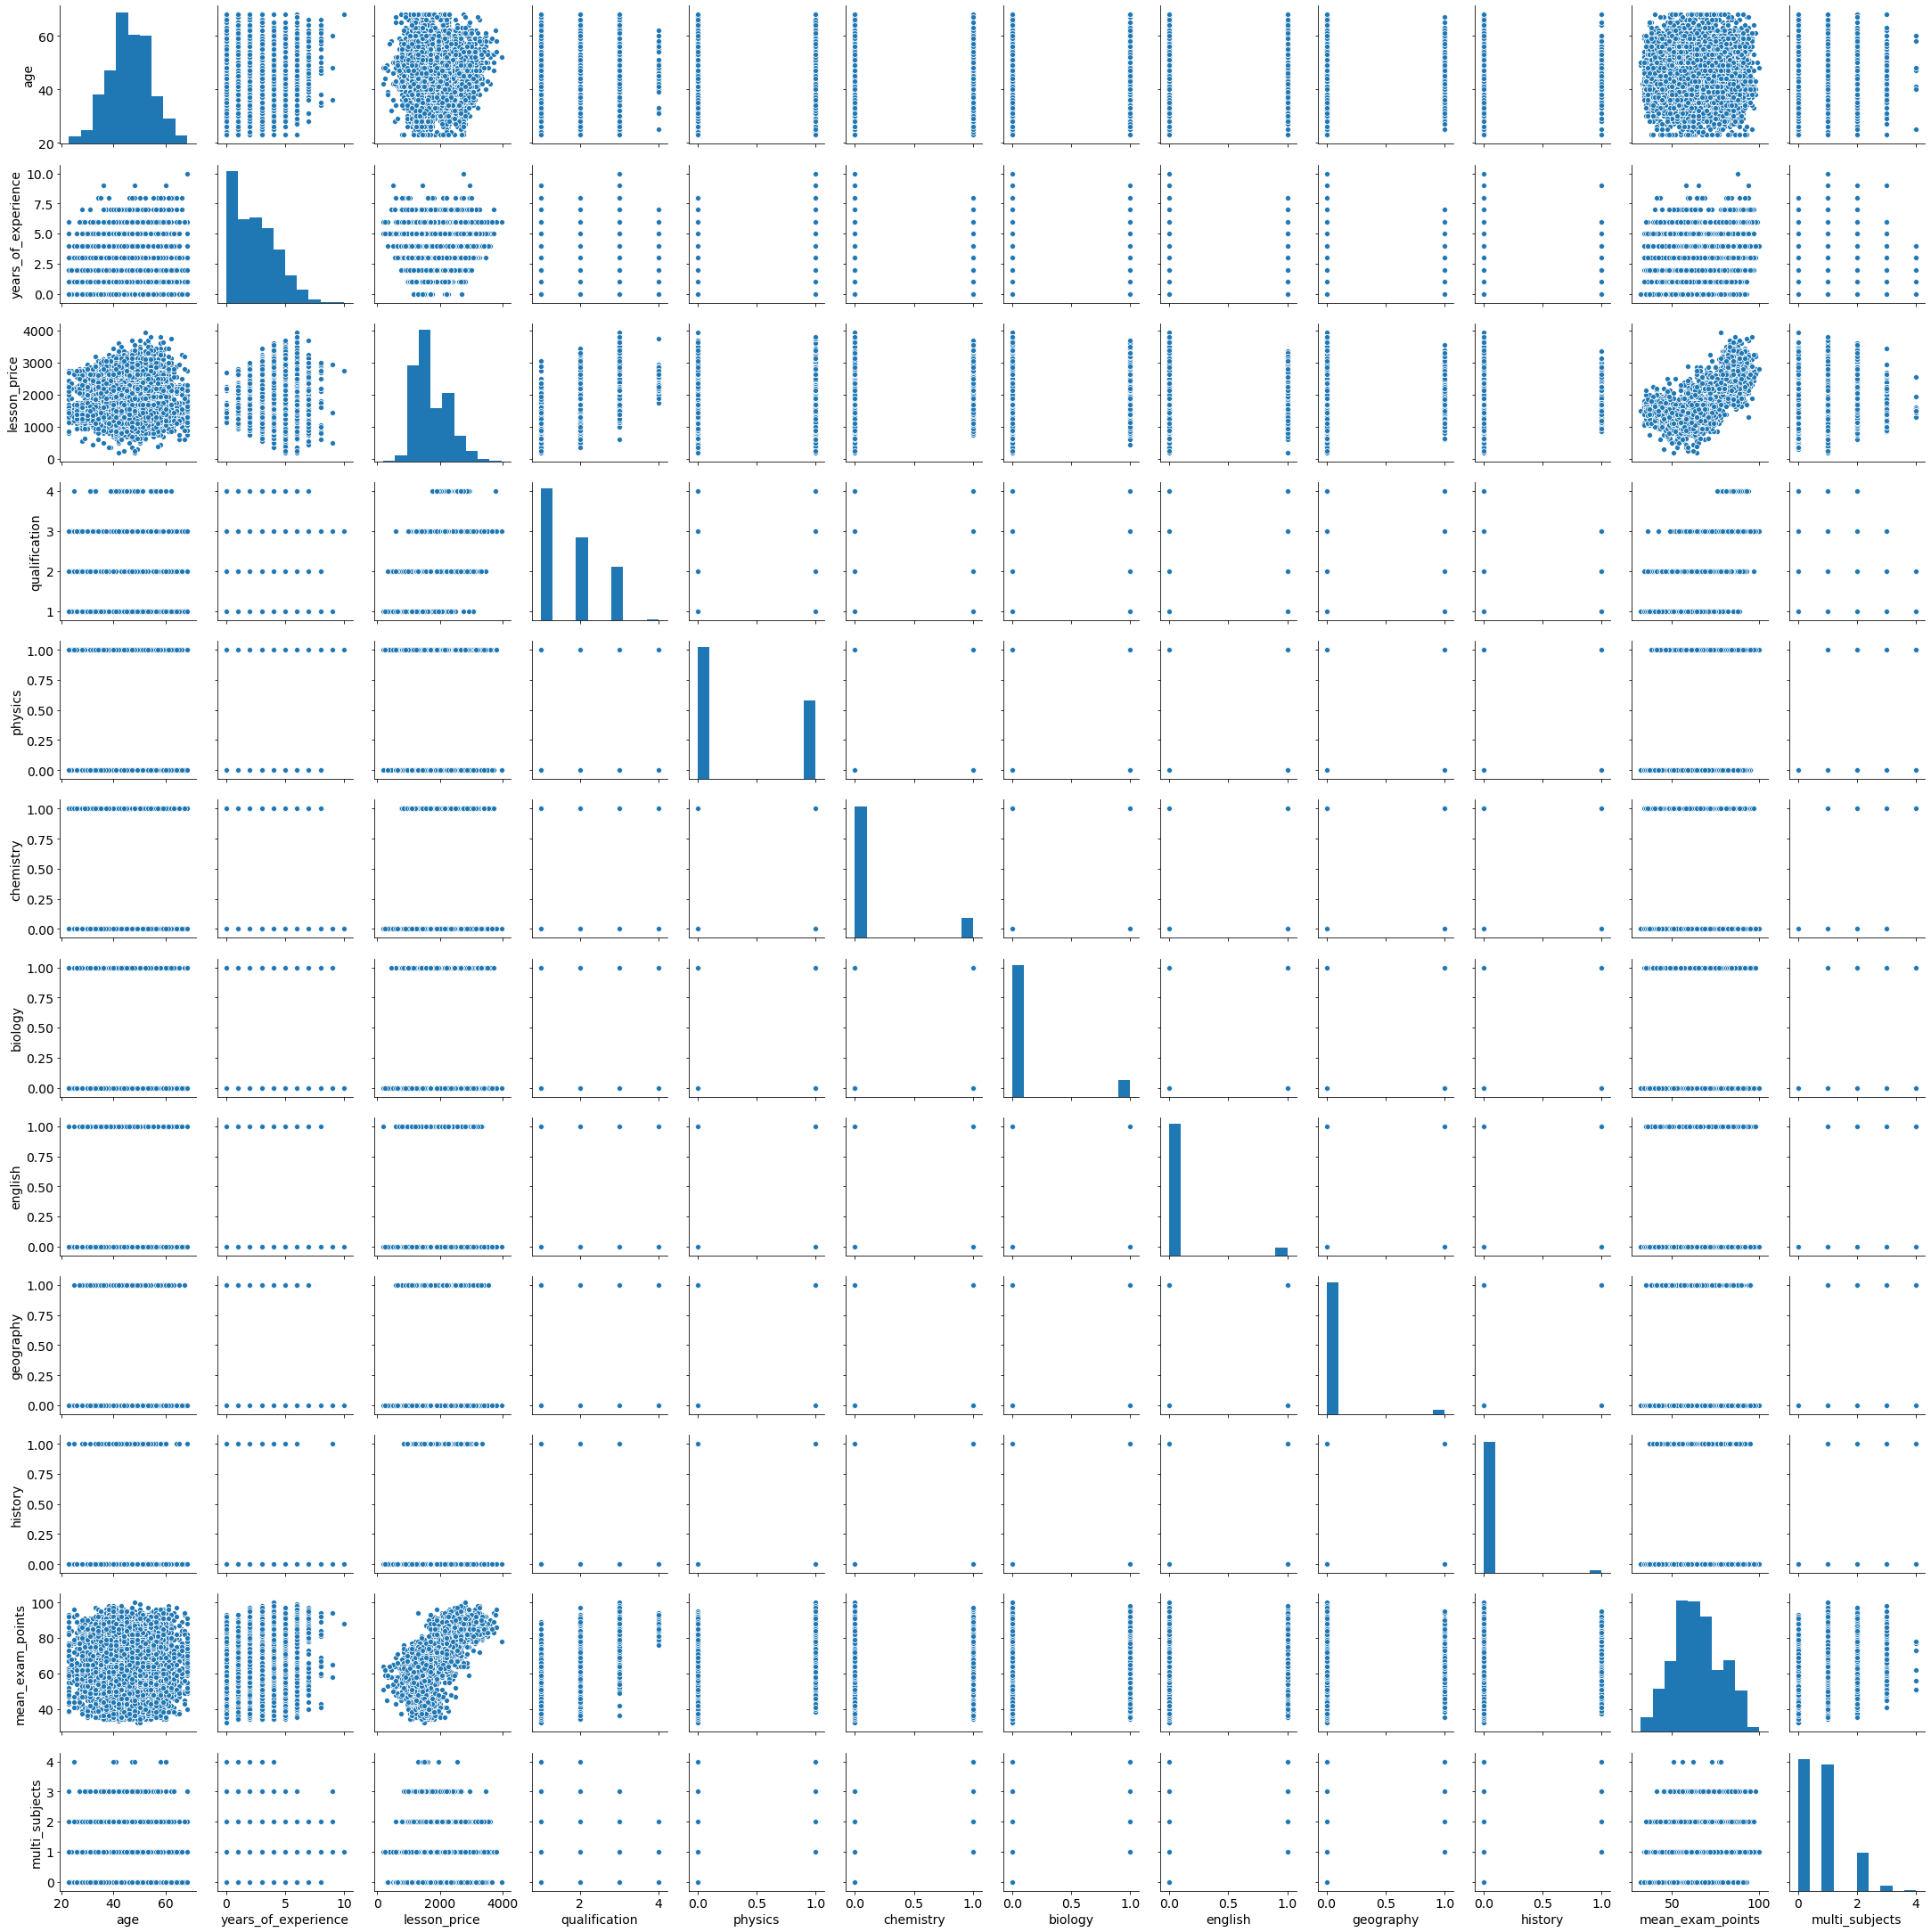

In [19]:
plt.figure(figsize=(18,18))
sns.pairplot(df_features)
plt.show()

В целом, намек на линейную зависимость можно заметить между целевой переменной и стоимостью урока, а также стоимостью урока и квалификации. В остальном все довольно хаотично

Посмотрим на матрицу корреляций

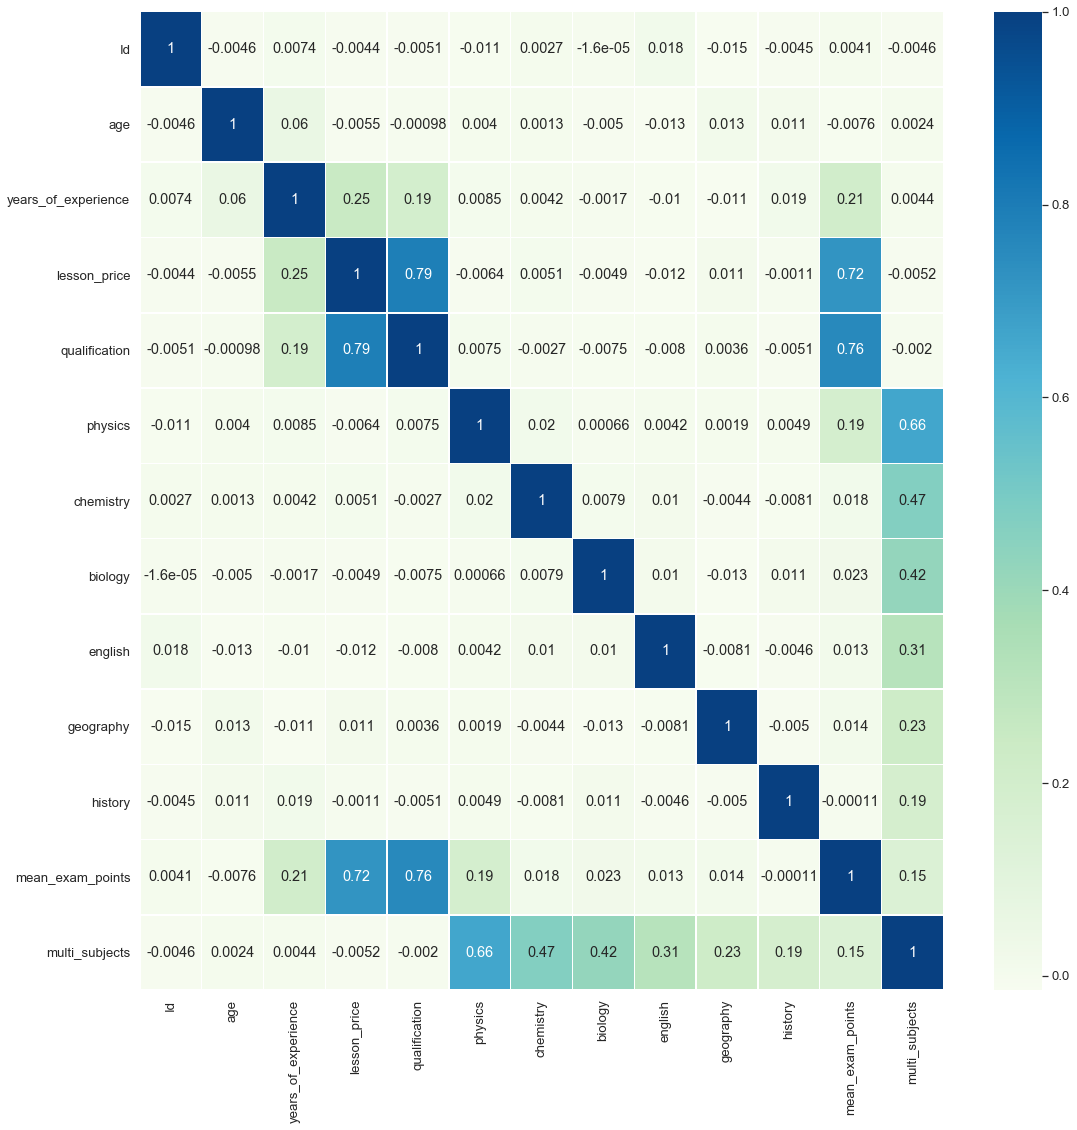

In [20]:
plt.figure(figsize=(18,18))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(), annot=True, linewidth=.5, cmap='GnBu')
plt.show()

Как и было заметно на предыдущих графиках, существует корреляция между средним баллом, стоимостью и квалификацией. Возможно, целесообразно будет сделать синтетический признак из квалификации и стоимости. Также можно заметить что преподаватели по физике относительно часто мультифункциональны :)

Подготовим признаки к обучению. Некоторые стандартизируем, некоторые нормируем

In [21]:
df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,multi_subjects
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800,0.722700
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823,0.747302
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000,1.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,4.000000


In [22]:
fields_to_std = ['age', 'years_of_experience', 'lesson_price']
fields_to_norm = ['qualification'] #,'multi_subjects']

In [23]:
scaler_std = StandardScaler()
scaler_norm = MinMaxScaler()

In [24]:
std_features = scaler_std.fit_transform(df[fields_to_std])
norm_features = scaler_norm.fit_transform(df[fields_to_norm])
df[fields_to_std] = pd.DataFrame(std_features, columns=fields_to_std, index=df.index)
df[fields_to_norm] = pd.DataFrame(norm_features, columns=fields_to_norm, index=df.index)

In [25]:
df.drop(columns=['subjects', 'multi_subjects'], inplace=True)
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,-0.730774,-1.121140,-0.569875,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,0.263815,1.136037,2.192764,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,-0.855098,-1.121140,-0.950929,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,0.015167,1.700332,-0.569875,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,-0.357803,-0.556846,-0.379348,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [26]:
fields_to_learn = ['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history'] #, 'multi_subjects']

In [27]:
X = np.array(df[fields_to_learn].T)
X_train = np.vstack((np.ones(X.shape[1]), X))
Y_train = np.array(df['mean_exam_points'].T)

Данных не очень много, поэтому используем классический градиентный спуск

In [28]:
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))
def RMSE(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [29]:
np.random.seed(42)

In [30]:
n = X_train.shape[1]
alpha = 4e-2
W = np.random.randn(X_train.shape[0])
print(f'Number of objects = {n} \
       \nLearning rate = {alpha} \
       \nInitial weights = {W} \n')
cgd_mse_history = []
cgd_r2_history = []
MAX_STEPS = 40
DELTA = 0.0005

for i in range(MAX_STEPS):
    y_pred = np.dot(W, X_train)
    cgd_mse_history.append(MSE(Y_train, y_pred))
    cgd_r2_history.append(r2_score(Y_train, y_pred))
    W -= alpha * (1/n * 2 * np.dot(X_train, (y_pred - Y_train)))

Number of objects = 10000        
Learning rate = 0.04        
Initial weights = [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769] 



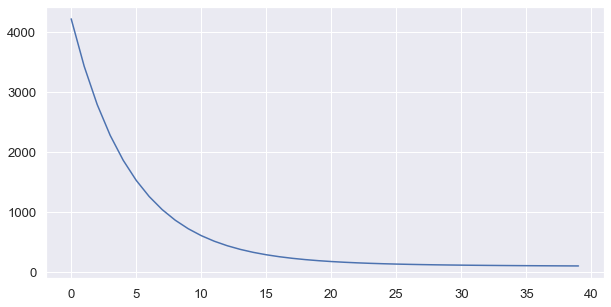

In [31]:
plt.figure(figsize=(10,5))
plt.plot(cgd_mse_history)
plt.show()

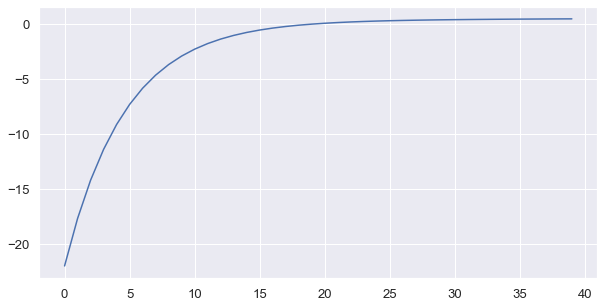

In [32]:
plt.figure(figsize=(10,5))
plt.plot(cgd_r2_history)
plt.show()

In [33]:
y_pred = np.dot(W, X_train)
cgs_mse = MSE(Y_train, y_pred)
cgs_r2 = r2_score(Y_train, y_pred)
cgs_mse, cgs_r2

(93.47893745231887, 0.489819692661695)

Как видно на графике, алгоритм очень быстро сошелся. Но в данных редко бывает абсолютно линейных зависимостей, поэтому попробуем улучшить результат, добавив в модель нелинейность

Гипотеза: линейную модель можно улучшить, добавив нелинейную составляющую, которую можно оптимизировать с помощью генетического алгоритма. Сами по себе генетические алгоритмы ресурсоемки, но если алгоритму предоставить предобученную модель, ему потребуется меньше времени для сходимости.

проверим это на простом примере:

In [34]:
X_ex = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 2, 1, 3, 0, 5, 10, 1, 2, 8, 9]
])
Y_ex = [45, 55, 50, 59, 65, 35, 75, 80, 50, 60, 65, 70]
n_ex = X_ex.shape[1]
alpha = 4e-2
W_ex = np.array([1, 0.5])
print(f'Number of objects = {n_ex} \
       \nLearning rate = {alpha} \
       \nInitial weights = {W_ex} \n')
for i in range(150):
    y_pred_ex = np.dot(W_ex, X_ex)
    W_ex -= alpha * (1/n_ex * 2 * np.dot(X_ex, (y_pred_ex - Y_ex)))

Number of objects = 12        
Learning rate = 0.04        
Initial weights = [1.  0.5] 



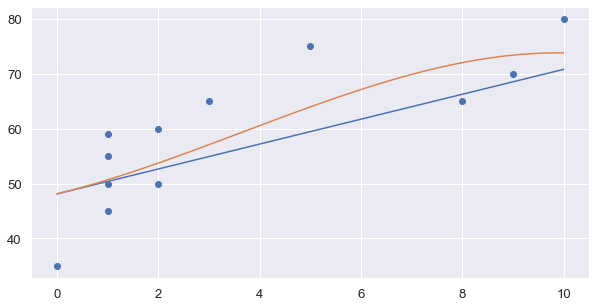

In [35]:
xv = np.linspace(0, 10, 100)
plt.figure(figsize=(10,5))
plt.scatter(X_ex[1], Y_ex)
plt.plot(xv, W_ex[0] + xv*W_ex[1])
plt.plot(xv, W_ex[0] + xv*W_ex[1] + 0.33*xv**2 - 0.03*xv**3 )
plt.show()

Синим цветом обозначена линия, полученная алгоритмом градиентного спуска. Оранжевым - кривая, подобранная вручную, которая более точно описывает данные

Попробуем оптимизировать с помощью генетического алгоритма

In [36]:
# в качестве генома используем веса нелинейной составляющей и степень полинома
class Item:
    def __init__(self, base_w, max_pow, mu):
        self.alpha = 100
        self.mu = mu
        self.base_weights = base_w
        self.base_len = len(base_w)
        self.max_pow = max_pow
        self.genetic_weights = np.random.randn((self.max_pow - 1)*self.base_len)/self.alpha
        self.weights = np.reshape(self.genetic_weights, ((self.max_pow - 1), self.base_len))
        self.pow = np.random.randint(2, max_pow + 1)
        self.mse_value = 0
        self.r2_value = 0
        self.drop_first()
    def predict_train(self, Y, X):
        y_pred = np.dot(self.base_weights, X)
        for i in range(self.pow-1):
            y_pred = y_pred + np.dot(self.weights[i], np.power(X, i+2))
        # self.mse_value = self.mse(Y, y_pred) - попробуем оптимизировать r2, т.к. на kaggle r2
        self.r2_value = self.r2(Y, y_pred)
        return y_pred
    def predict(self, X):
        y_pred = np.dot(self.base_weights, X)
        for i in range(self.pow-1):
            y_pred = y_pred + np.dot(self.weights[i], np.power(X, i+2))
        return y_pred
    def drop_first(self):
        for i in range(0, (self.max_pow-1)*self.base_len, self.base_len):
            self.genetic_weights[i] = 0
    def mse(self, y, y_pred):
        return np.mean(np.square(y - y_pred))
    def r2(self, y, y_pred):
        return r2_score(y, y_pred)
    def get_mse(self):
        return self.mse_value
    def get_r2(self):
        return self.r2_value
    def mutations(self):
        for i in range(len(self.genetic_weights)):
            if np.random.choice([1,0], p=[self.mu, 1-self.mu]):
                self.genetic_weights[i] = self.genetic_weights[i] + np.random.normal(0, 1)/100
        self.drop_first()
    def set_genetic(self, g_code, g_pow):
        self.genetic_weights = g_code
        self.weights = np.reshape(self.genetic_weights, ((self.max_pow - 1), self.base_len))
        self.pow = g_pow
        self.mse_value = 0
        self.r2_value = 0
    def get_genetic(self):
        return {'weights': self.genetic_weights, 'pow': self.pow}

In [160]:
MAX_POW = 10 # максимальная степень полинома
MUTATION_COEF = 0.1 # коэффициент мутации каждого гена
BASE_LEN = len(W_ex) #длина линейной части
W_ARRAY = np.arange((MAX_POW-1)*BASE_LEN)
MID_ARRAY = len(W_ARRAY) // 2
LEN_ARRAY = len(W_ARRAY)
# вероятность положения точки скрещивания. Чтобы не создавать клонов обнуляем крайние положения
PROBS = norm.pdf(W_ARRAY, MID_ARRAY)
PROBS[MID_ARRAY] = PROBS[MID_ARRAY] + (1 - sum(PROBS))
PROBS[MID_ARRAY-1] = PROBS[MID_ARRAY-1] + PROBS[0]
PROBS[0] = 0
PROBS[MID_ARRAY] = PROBS[MID_ARRAY] + PROBS[LEN_ARRAY-1]
PROBS[LEN_ARRAY-1] = 0
POPULATION_SIZE = 100
HALF_SIZE = int(POPULATION_SIZE/2)
NUM_OF_EPOCH = 1000

In [161]:
# функция скрещивания
def crossing(item1:Item, item2:Item, W):
    t_obj1 = Item(W, MAX_POW, MUTATION_COEF)
    t_obj2 = Item(W, MAX_POW, MUTATION_COEF)
    w1 = np.zeros(LEN_ARRAY)
    w2 = np.zeros(LEN_ARRAY)
    selection_point = np.random.choice(LEN_ARRAY, p=PROBS)
    w1[:selection_point] = item1.get_genetic()['weights'][:selection_point]
    w1[selection_point:] = item2.get_genetic()['weights'][selection_point:]
    w2[:selection_point] = item2.get_genetic()['weights'][:selection_point]
    w2[selection_point:] = item1.get_genetic()['weights'][selection_point:]
    p1 = item1.get_genetic()['pow']
    p2 = item2.get_genetic()['pow']
    # mse1 = item1.get_mse()
    # mse2 = item2.get_mse()
    r2_1 = item1.get_r2()
    r2_2 = item2.get_r2()
    # new_pow1 = np.random.choice([p1, p2], p=[(1 - mse1/(mse1+mse2)), (1 - mse2/(mse1+mse2))])
    # new_pow2 = np.random.choice([p1, p2], p=[(1 - mse1/(mse1+mse2)), (1 - mse2/(mse1+mse2))])
    if (r2_1 < 0 or r2_1 > 1):
        r2_1 = 0
    if (r2_2 < 0 or r2_2 > 1):
        r2_2 = 0
    r2_sum = r2_1 + r2_2
    prob_1 = 0.5
    prob_2 = 0.5
    if (r2_sum != 0):
        prob_1 = (1 - r2_2/r2_sum)
        prob_2 = (1 - r2_1/r2_sum)
    #print('CROSSING:', r2_1, r2_2, r2_sum, prob_1, prob_2)
    new_pow1 = np.random.choice([p1, p2], p=[prob_2, prob_1])
    new_pow2 = np.random.choice([p1, p2], p=[prob_2, prob_1])
    t_obj1.set_genetic(w1.copy(), new_pow1)
    t_obj2.set_genetic(w2.copy(), new_pow1)
    return [t_obj1, t_obj2]

In [162]:
population_pool = [Item(W_ex, MAX_POW, MUTATION_COEF) for i in range(POPULATION_SIZE)]
# mse_pool = np.zeros(POPULATION_SIZE)
# mse_history = []
r2_pool = np.zeros(POPULATION_SIZE)
r2_history = []
best_idx = 0

In [163]:
for e in tqdm(range(NUM_OF_EPOCH)):
    for i in range(POPULATION_SIZE):
        population_pool[i].predict_train(Y_ex,X_ex)
        # mse_pool[i] = population_pool[i].get_mse()
        r2_pool[i] = population_pool[i].get_r2()
    if(e == NUM_OF_EPOCH-1):
        break
    r2_history.append(max(r2_pool)) # min для MSE
    # selection
    idx = np.argsort(r2_pool)[::-1] #.argsort() для MSE
    best_idx = idx[0]
    best_r2 = r2_pool[best_idx]
    if best_r2 > 0.99 and best_r2 < 1:
        break
    # make pairs
    pairs = np.zeros((HALF_SIZE,2), dtype=int)
    for i in range(HALF_SIZE):
        pairs[i][0] = int(np.random.choice(idx[:HALF_SIZE]))
        pairs[i][1] = int(np.random.choice(idx[:HALF_SIZE]))

    new_population = []
    for i in range(HALF_SIZE):
        new_population = new_population + (crossing(population_pool[pairs[i][0]],population_pool[pairs[i][1]],W_ex))
    
    for i in range(POPULATION_SIZE):
        new_population[i].mutations()
    population_pool = None
    population_pool = new_population

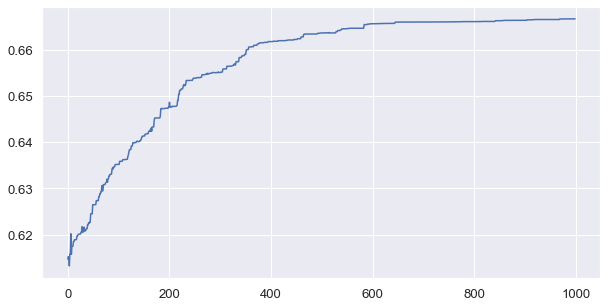

In [164]:
plt.figure(figsize=(10,5))
plt.plot(range(len(r2_history)), r2_history)
plt.show()

In [165]:
# посмотрим на предсказания лучшего экземпляра из последней популяции
y_q = population_pool[best_idx].predict(X_ex)

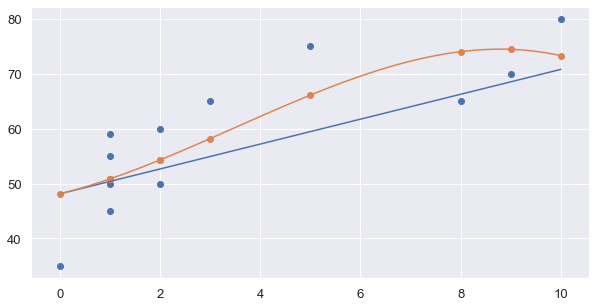

In [166]:
xv = np.linspace(0, 10, 100)
funcy = [population_pool[best_idx].predict([1, i]) for i in xv]
plt.figure(figsize=(10,5))
plt.scatter(X_ex[1], Y_ex)
plt.plot(xv, W_ex[0] + xv*W_ex[1])
plt.plot(xv, funcy)
plt.scatter(X_ex[1], y_q)
plt.show()

In [167]:
population_pool[best_idx].get_genetic()

{'weights': array([ 0.        ,  0.5072334 ,  0.        , -0.04824668,  0.        ,
         0.06669407,  0.        ,  0.194271  ,  0.        ,  0.05477561,
         0.        ,  0.0433518 ,  0.        , -0.00813753,  0.        ,
         0.0719396 ,  0.        , -0.03583806]),
 'pow': 3}

In [168]:
y_pred_ex = np.dot(W_ex, X_ex)
population_pool[best_idx].get_r2(), r2_score(Y_ex, y_pred_ex)

(0.6667126613412008, 0.5715453075945558)

MSE после оптимизации снизилась. А R2 увеличилась. Кроме того были выявлены следующие моменты:
 - генетический алгоритм очень устойчив к переобучению. По крайней мере, имея "базовую" модель, которая указывает на общее направление. Даже при максимальной степени полинома 10, в итоге получался экземпляр с 3й
 - высокий коэффициент мутации ускоряет сходимость, но результат хуже (ошибка больше)
 - генетический алгоритм почти повторил ту кривую, которую сделали изначально вручную!

Теперь попробуем применить это на нашей задаче

In [169]:
MAX_POW = 10 # максимальная степень полинома
MUTATION_COEF = 0.1 # коэффициент мутации каждого гена
BASE_LEN = len(W) #длина линейной части
W_ARRAY = np.arange((MAX_POW-1)*BASE_LEN)
MID_ARRAY = len(W_ARRAY) // 2
LEN_ARRAY = len(W_ARRAY)
# вероятность положения точки скрещивания. Чтобы не создавать клонов обнуляем крайние положения
PROBS = norm.pdf(W_ARRAY, MID_ARRAY)
PROBS[MID_ARRAY] = PROBS[MID_ARRAY] + (1 - sum(PROBS))
PROBS[MID_ARRAY-1] = PROBS[MID_ARRAY-1] + PROBS[0]
PROBS[0] = 0
PROBS[MID_ARRAY] = PROBS[MID_ARRAY] + PROBS[LEN_ARRAY-1]
PROBS[LEN_ARRAY-1] = 0
POPULATION_SIZE = 100
HALF_SIZE = int(POPULATION_SIZE/2)
NUM_OF_EPOCH = 3000

In [170]:
population_pool = [Item(W, MAX_POW, MUTATION_COEF) for i in range(POPULATION_SIZE)]
r2_pool = np.zeros(POPULATION_SIZE)
r2_history = []
best_idx = 0

In [171]:
# напомним, какой получилась R2 в линейной регрессии
y_pred = np.dot(W, X_train)
cgs_r2 = r2_score(Y_train, y_pred)
cgs_r2

0.489819692661695

In [172]:
for e in tqdm(range(NUM_OF_EPOCH)):
    for i in range(POPULATION_SIZE):
        population_pool[i].predict_train(Y_train,X_train)
        # mse_pool[i] = population_pool[i].get_mse()
        r2_pool[i] = population_pool[i].get_r2()
    if(e == NUM_OF_EPOCH-1):
        break
    r2_history.append(max(r2_pool)) # min для MSE
    # selection
    idx = np.argsort(r2_pool)[::-1] #.argsort() для MSE
    best_idx = idx[0]
    best_r2 = r2_pool[best_idx]
    if best_r2 > 0.99 and best_r2 < 1:
        break
    # make pairs
    pairs = np.zeros((HALF_SIZE,2), dtype=int)
    for i in range(HALF_SIZE):
        pairs[i][0] = int(np.random.choice(idx[:HALF_SIZE]))
        pairs[i][1] = int(np.random.choice(idx[:HALF_SIZE]))

    new_population = []
    for i in range(HALF_SIZE):
        new_population = new_population + (crossing(population_pool[pairs[i][0]],population_pool[pairs[i][1]],W))
    
    for i in range(POPULATION_SIZE):
        new_population[i].mutations()
    population_pool = None
    population_pool = new_population

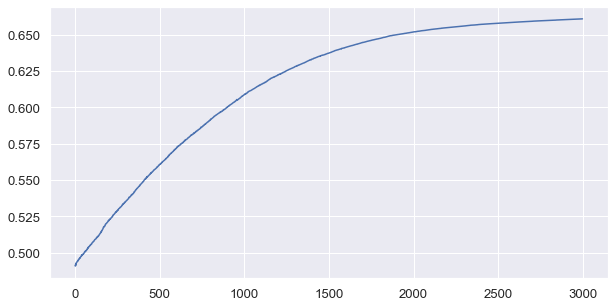

In [173]:
plt.figure(figsize=(10,5))
plt.plot(range(len(r2_history)), r2_history)
plt.show()

In [174]:
population_pool[best_idx].get_genetic()

{'weights': array([ 0.00000000e+00,  1.05936144e+00,  1.42777472e+00,  3.96490659e+00,
         2.93286315e+00, -2.24783820e+00, -1.99084583e+00, -1.03343539e+00,
        -1.10412710e-01, -3.12948949e-02, -1.27990351e-01,  0.00000000e+00,
         5.87970698e-02, -8.26917509e-01, -7.45071492e-01,  1.71866606e+00,
        -2.66586797e+00, -1.31487054e+00, -1.39035799e+00,  3.41639426e-02,
        -1.10565072e-01,  2.15396437e-01,  0.00000000e+00, -1.34383610e-01,
         9.17879606e-02, -1.95138524e-01,  7.30721972e-01, -2.77965637e+00,
        -1.69310541e+00, -9.58953504e-01, -4.46324191e-01, -2.06758750e-01,
         1.81649912e-01,  0.00000000e+00, -9.65205348e-02, -2.12128870e-01,
         7.34951943e-02,  1.89120468e-01,  1.56012974e-01, -5.11290816e-02,
        -3.60081138e-02,  8.85066504e-02,  2.81260973e-01,  4.34423449e-02,
         0.00000000e+00, -1.00702368e-01, -1.79586195e-01,  1.88297067e-01,
        -7.87309691e-02, -3.37929653e-01,  5.01084138e-02,  1.08576478e-01,
 

В целом, R2 (и MSE) почти достигла плато. Посмоторим R2 лучшего экземпляра

In [175]:
y_best = population_pool[best_idx].predict(X_train)

In [178]:
population_pool[best_idx].get_r2()

0.660947129363211

Таким образом, мы улучшили результат чуть более чем в 1.3 раза (в 1.6 для MSE)

In [180]:
#with open('g_code_r2.npy', 'wb') as f:
#    np.save(f, population_pool[best_idx].get_genetic()['weights'])
#    np.save(f, np.array([population_pool[best_idx].get_genetic()['pow']]))
#with open('g_code.npy', 'rb') as f:
#    gwts = np.load(f)
#    gpws = np.load(f)

Теперь сделаем предсказание на выборке для kaggle

In [181]:
pdf = pd.read_csv('test.csv')

In [182]:
#columns = pdf.columns.values.tolist()
#pdf['multi_subjects'] = sum([pdf[columns[i]] for i in range(5, 11)])

In [183]:
std_features = scaler_std.fit_transform(pdf[fields_to_std])
norm_features = scaler_norm.fit_transform(pdf[fields_to_norm])
pdf[fields_to_std] = pd.DataFrame(std_features, columns=fields_to_std, index=pdf.index)
pdf[fields_to_norm] = pd.DataFrame(norm_features, columns=fields_to_norm, index=pdf.index)

In [184]:
X = np.array(pdf[fields_to_learn].T)
X_real = np.vstack((np.ones(X.shape[1]), X))

In [185]:
y_real = population_pool[best_idx].predict(X_real)

In [186]:
y_real

array([53.06004673, 60.63913035, 57.74834948, ..., 54.06672925,
       60.87210611, 70.45323488])

In [187]:
response = pd.DataFrame(pdf['Id'])

In [188]:
response['mean_exam_points'] = y_real

In [189]:
response.to_csv('submit_r2.csv', index=False)

Выводы:

1. Если в данных с линейной зависимостью присутствует небольшая нелинейная зависимость, она может быть найдена и оптимизирована с помощью генетических алгоритмов.
2. Если в данных присутствует серьезная нелинейная составляющая, то наличие "базовой" генетики в виде линейной модели будет мешать генетическому алгоритму оптимизировать популяцию под данные.
3. Генетические алгоритмы имеют очень высокую вычислительную сложность, поэтому применять их лучше там, где никакие другие средства не подошли. 
4. Если в данных мало значений с линейными зависимостями, лучше пробовать другие алгоритмы, чем градиентный спуск.